### 1. Import Dependencies

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

maze = np.array([
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
    [1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
    [1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
    [1, 0, 1, 0, 0, 0, 0, 0, 1, 1],
    [1, 0, 1, 0, 1, 1, 1, 0, 1, 1],
    [1, 0, 1, 0, 1, 0, 0, 0, 1, 1],
    [1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
    [1, 1, 1, 0, 1, 1, 1, 1, 0, 0]
])

start = (0, 0)
goal = (9, 9)

### 2. Set RL parameter and Q table

In [3]:
# จำนวนครั้งที่ agent พยายามหาค่าผ่านเขาวงกต
num_episodes = 5000

# การเรียนรู้ที่จะควบคุมว่าข้อมูลใหม่จะเข้ามาแทนที่ข้อมูลเก่ามากน้อยเพียงใด
alpha = 0.1

# ปัจจัยส่วนลดที่ให้ความสำคัญกับผลตอบแทนในทันนีมากกว่า
gamma = 0.9

# ความน่าจะเป็นของการสำรวจเทียบกับการใช้ประโยชน์ โดยค่าเอปซิลอนจะสูงกว่าหากสำรวจมากกว่า
epsilon = 0.5


reward_fire = -10
reward_goal = 50
reward_step = -1

actions = [(0, -1), (0, 1), (-1, 0), (1, 0)]

# Q  คือตาราง Q ที่เริ่มต้นด้วยค่าศูนย์ โดยจะเก็บค่ารางวัลที่คาดหวังสำหรับแต่ละคู่สถานะ-การกระทำ
Q = np.zeros(maze.shape + (len(actions), ))


### 3. Detected functions and choose actions

In [4]:
# is_valid ช่วยให้มั่นใจได้ว่าเอเจนต์สามารถเคลื่อนที่ได้เฉพาะภายในเขาวงกตและหลีกเลี่ยงสิ่งกีดขวางเท่านั้น
def is_valid(pos):
    r, c = pos
    if r < 0 or r >= maze.shape[0]:
        return False
    if c < 0 or c >= maze.shape[1]:
        return False
    if maze[r, c] == 1:
        return False
    
# choose_action เป็นการนำกลยุทธ์การสำรวจ (การกระทำแบบสุ่ม) กับการใช้ประโยชน์ (การกระทำที่เรียนรู้ได้ดีที่สุด) มาใช้
def choose_action(state):
    if np.random.random() < epsilon:
        return np.random.randint(len(actions))
    else:
        return np.argmax(Q[state])

### 4. Training agent with Q-Learning Algorithm

Q-Learning rule:
    ![alt text](<สกรีนช็อต 2026-01-06 021935.png>)
    ![alt text](<สกรีนช็อต 2026-01-06 022102-1.png>)

In [ ]:
reward_all_episodes = []

for episode in range(num_episodes):
    state = start
    total_rewards = 0
    done = False

    while not done:
        action_index = choose_action(state)
        action = actions[action_index]

        next_state = (state[0] + action[0], state[1] + action[1])

        if not is_valid(next_state):
            reward = reward_fire
            done = True
        elif next_state == goal:
            reward = reward_goal
            done = True
        else:
            reward = reward_step

        old_value = Q[state][action_index]
        next_max = np.max(Q[next_state]) if is_valid(next_state) else 0

        Q[state][action_index] = old_value + alpha * \
            (reward + gamma * next_max - old_value)

        state = next_state
        total_rewards += reward

    global epsilon
    epsilon = max(0.01, epsilon * 0.995)
    reward_all_episodes.append(total_rewards)


### 5. Extract the optimal path after training

- ฟังก์ชันนี้จะติดตามค่า Q สูงสุดในแต่ละสถานะเพื่อหาเส้นทางที่ดีที่สุด
- เกมจะหยุดเมื่อบรรลุเป้าหมายหรือไม่มีการดำเนินการใดที่ถูกต้องอีกต่อไป
- ชุดที่ถูกเยี่ยมชมจะป้องกันการวนซ้ำ

In [7]:
def get_optimal_path(Q, start, goal, actions, maze, max_steps=200):
    path = [start]
    state = start
    visited = set()

    for _ in range(max_steps):
        if state == goal:
            break
        visited.add(state)

        best_action = None
        best_value = -float('inf')

        for idx, move in enumerate(actions):
            next_state = (state[0] + move[0], state[1] + move[1])

            if (0 <= next_state[0] < maze.shape[0] and
                0 <= next_state[1] < maze.shape[1] and
                maze[next_state] == 0 and
                    next_state not in visited):
                
                if Q[state][idx] > best_value:
                    best_value = Q[state][idx]
                    best_action = idx

        if best_action is None:
            break

        move = actions[best_action]
        state = (state[0] + move[0], state[1] + move[1])
        path.append(state)

    return path

optimal_path = get_optimal_path(Q, start, goal, actions, maze)

### 6. Virtualize the Maze, Robot Path, Start and Goal

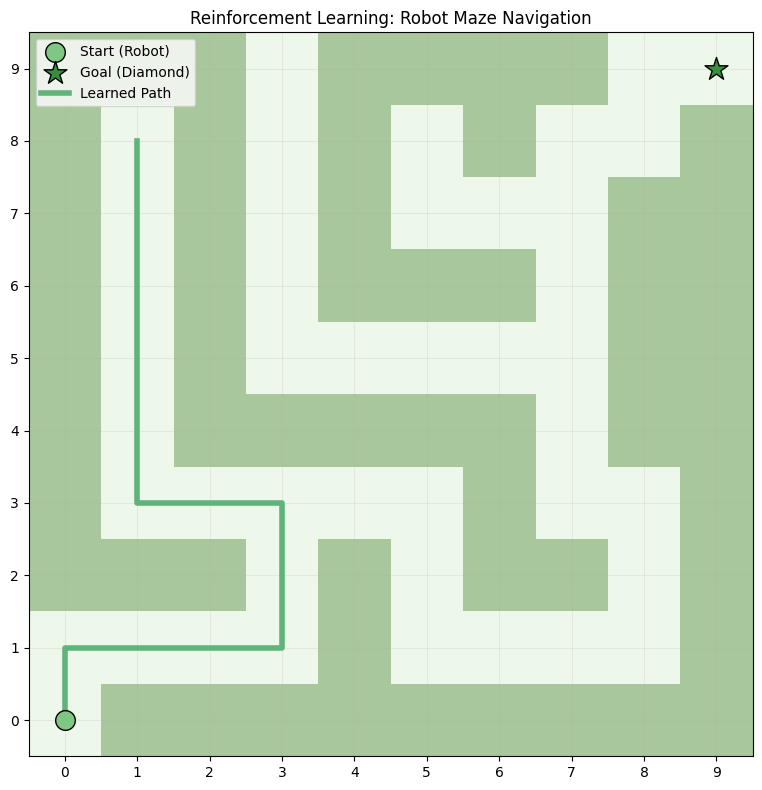

In [11]:
def plot_maze_with_path(path):
    cmap = ListedColormap(['#eef8ea', '#a8c79c'])

    plt.figure(figsize=(8, 8))
    plt.imshow(maze, cmap=cmap)

    plt.scatter(start[1], start[0], marker='o', color='#81c784', edgecolors='black',
                s=200, label='Start (Robot)', zorder=5)
    plt.scatter(goal[1], goal[0], marker='*', color='#388e3c', edgecolors='black',
                s=300, label='Goal (Diamond)', zorder=5)
    
    rows, cols = zip(*path)
    plt.plot(cols, rows, color='#60b37a', linewidth=4,
             label='Learned Path', zorder=4)
    
    plt.title('Reinforcement Learning: Robot Maze Navigation')
    plt.gca().invert_yaxis()
    plt.xticks(range(maze.shape[1]))
    plt.yticks(range(maze.shape[0]))
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_maze_with_path(optimal_path)
    

### 7. Plot Rewards per Training

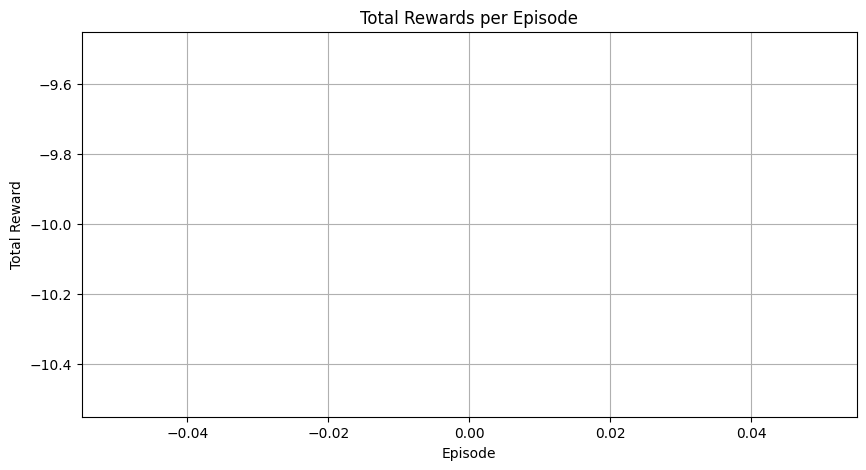

In [12]:
def plot_rewards(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.title('Total Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()

plot_rewards(total_rewards)